# Purple_CCF calculation in sarcoma sample and clonal mutations filtering

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [3]:
# Import filtered mutation files 
common_mut_df = pd.read_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_List_common_mutations_callers.tsv.gz', sep="\t", header=0)

# Import purity value
purple_purity_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp2/purple/AX4967.purple.purity.tsv', sep="\t", header=0)
purple_cnv_df = pd.read_csv('/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp2/purple/AX4967.purple.cnv.somatic.tsv', sep="\t", header=0)

In [4]:
common_mut_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,124,46,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,126,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,141,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,153,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,123,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T


In [5]:
# Extract purity value from table, note that this value is the Aberrant Cell Fraction
purity = purple_purity_df['purity']
purity

0    0.69
Name: purity, dtype: float64

## 1/ Processing CNV file

In [6]:
purple_cnv_df.head()

,chromosome,start,end,copyNumber,bafCount,observedBAF,baf,segmentStartSupport,segmentEndSupport,method,depthWindowCount,gcContent,minStart,maxStart,minorAlleleCopyNumber,majorAlleleCopyNumber
0,chr1,1,10146,1.6052,0,0.0000,0.9754,TELOMERE,BND,STRUCTURAL_VARIANT,0,0.0000,1,1,0.0394,1.5657
1,chr1,10147,1484207,1.4411,262,0.7938,0.9726,BND,BND,BAF_WEIGHTED,212,0.6065,10147,10147,0.0394,1.4017
2,chr1,1484208,14842626,1.3481,9446,0.7938,0.9902,BND,DUP,BAF_WEIGHTED,10905,0.4874,1484208,1484208,0.0132,1.3348
3,chr1,14842627,15712729,2.7229,797,0.8739,0.9973,DUP,DUP,BAF_WEIGHTED,832,0.4855,14842627,14842627,0.0074,2.7155
4,chr1,15712730,21704616,1.3694,3562,0.7962,0.9905,DUP,BND,BAF_WEIGHTED,5181,0.4855,15712730,15712730,0.0129,1.3564


In [7]:
# Purple CNV file has information of copy number calculated, it is the copyNumber column and is the sum of minorAlleleCopyNumber and majorAlleleCopyNumber

purple_cnv_df = purple_cnv_df[['chromosome','start','end','copyNumber']] # select columns of interest
purple_cnv_df = purple_cnv_df.rename(columns={'chromosome':'chrom','copyNumber':'CN'})

In [8]:
# Calculate copy number (CN) from cnv files and add it as new column 
purple_cnv_df[['CN']] = purple_cnv_df[['CN']].astype(float) # convert so it is float, if not it converts it to integer/object

## 2/ Add CN to common mutations df with Pybedtools

In [9]:
# Pybedtools package: see https://daler.github.io/pybedtools/main.html for documentation
# installed in conda environment through terminal with: pip install pybedtools
# Modify the path of BedTools in bashrc file to be able to execute pybedtools globally.
# Now import the library

import pybedtools

In [10]:
# To use pybedtools POS column of common_mut_df should have another coordenate like end position. To do so, duplicate the information of POS column

mutations_df = pd.DataFrame({
    'CHROM': common_mut_df['CHROM'],
    'start': common_mut_df['POS'],
    'end': common_mut_df['POS'] + 1, # duplicate this column so it is considered a "bed file"
    'REF': common_mut_df['REF'],
    'ALT': common_mut_df['ALT']
    
})

mutations_df

,CHROM,start,end,REF,ALT
0,chr1,104188,104189,C,A
1,chr1,843320,843321,G,A
2,chr1,1014876,1014877,G,T
3,chr1,1118520,1118521,C,T
4,chr1,1136548,1136549,G,T
...,...,...,...,...,...
24290,chrY,26654389,26654390,A,G
24291,chrY,56823266,56823267,G,A
24292,chrY,56842066,56842067,CT,AC
24293,chrY,56842087,56842088,T,C


In [11]:
# Convert dataframes to a BedTool object so it could be processed with pybedtools
mutations_bt = pybedtools.BedTool.from_dataframe(mutations_df)
purple_cnv_bt = pybedtools.BedTool.from_dataframe(purple_cnv_df)

In [12]:
# Use intersect method of Bedtools to intersect (see https://daler.github.io/pybedtools/intersections.html)
cnv_bt = purple_cnv_bt.intersect(mutations_bt) #save intersect table into a new dataframe

In [13]:
# Convert cnv bedtool object into a dataframe. 
cnv_df = cnv_bt.to_dataframe(header=None) # Note that "chrom, start, end, name" columns are by default even using "header = None".

In [14]:
# Rename columns of cnv dataframe
cnv_df = cnv_df.rename(columns={'chrom':'CHROM','start':'POS','end':'POS2','name':'CN'})

# Drop POS2 column, which is an artificial column we created previously
cnv_df = cnv_df.drop(columns='POS2')

In [15]:
# We are loosing this number of mutations with the intersect method (?!)
len(mutations_df) - len(cnv_df)

1

In [16]:
cnv_df.head()

,CHROM,POS,CN
0,chr1,104188,1.4411
1,chr1,843320,1.4411
2,chr1,1014876,1.4411
3,chr1,1118520,1.4411
4,chr1,1136548,1.4411


## 3/ Calculate CCF

In [17]:
# Merge intersect with common_mut_df adding left indicates: use only keys from left frame, preserve key order
mutations_cnv_df = pd.merge(common_mut_df,cnv_df,how='left')

In [18]:
mutations_cnv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_alt_reads,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,46,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,1.4411
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,69,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,1.4411
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,6,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,1.4411
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,45,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,1.4411
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,90,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,1.4411


In [19]:
# Check in CN column which mutations have non NaN values. Note that returns the same number of rows of cnv_df length.
nan_values = mutations_cnv_df[~mutations_cnv_df['CN'].isna()]

In [20]:
# Add 2 in CN with NaN values, because these positions despite were not in the cnv file are diploid
mutations_cnv_df['CN'].fillna(2, inplace=True) 
# Convert columns to float so they are operable to calculate CCF
mutations_cnv_df[['VAF','CN']] = mutations_cnv_df[['VAF','CN']].astype(float)

In [21]:
# Define a function to calculate CCF from VAF, copy number and purity values
def get_ccf(row):
    row = row['VAF'] * (purity * row['CN'] + (1 - purity) * 2) / purity
    return row

mutations_cnv_df['CCF'] = mutations_cnv_df.progress_apply(get_ccf, axis=1)

  0%|          | 0/24295 [00:00<?, ?it/s]

In [22]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_alt_reads,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,0,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,1.4411,0.935860
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,1.4411,1.195821
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,0,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,1.4411,0.103220
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,1.4411,0.741439
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,1.4411,1.452197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24290,chrY,26654389,.,A,G,864,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,0,19,57,0.683000,SNV,Strelka_SAGE,sarcoma,chrY_26654389_A_G,0.5867,1.014426
24291,chrY,56823266,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=487,411|29,27...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:456,0:2.167e-03:456:195,0:201,0:448,0:238,...",...,0,442,456,0.112450,SNV,Mutect_Strelka,sarcoma,chrY_56823266_G_A,0.5867,0.167016
24292,chrY,56842066,.,CT,AC,1323,PASS,LPS=6133;LPS_RC=42;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,0,169,290,0.305000,MNV,Mutect_SAGE,sarcoma,chrY_56842066_CT_AC,0.5867,0.453001
24293,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=241,235|34,34...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,0,181,295,0.273092,SNV,Mutect_Strelka,sarcoma,chrY_56842087_T_C,0.5867,0.405611


## 4/ Histograms representing CCF

In [23]:
ccf = mutations_cnv_df['CCF'].copy()  # Extract the 'CCF' column
ccf = pd.to_numeric(ccf, errors='coerce')  # Convert values to numeric, coerce errors
ccf

0        0.935860
1        1.195821
2        0.103220
3        0.741439
4        1.452197
           ...   
24290    1.014426
24291    0.167016
24292    0.453001
24293    0.405611
24294    0.063866
Name: CCF, Length: 24295, dtype: float64

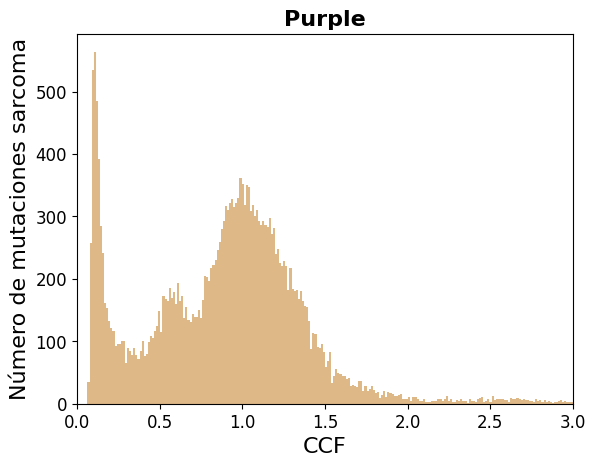

In [24]:
# Represent histogram without density plot

plt.hist(ccf.tolist(), bins = 500, color = "burlywood")
plt.xlim([0,3])
plt.ylabel('Número de mutaciones sarcoma', fontsize=16)
plt.xlabel('CCF', fontsize=16)
plt.title('Purple',fontsize=16, weight ='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_purple_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(ccf.tolist())

/tmp/jobs/efiguerola/9577475/ipykernel_3551618/2607040284.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ccf, bins=200, color = 'burlywood')


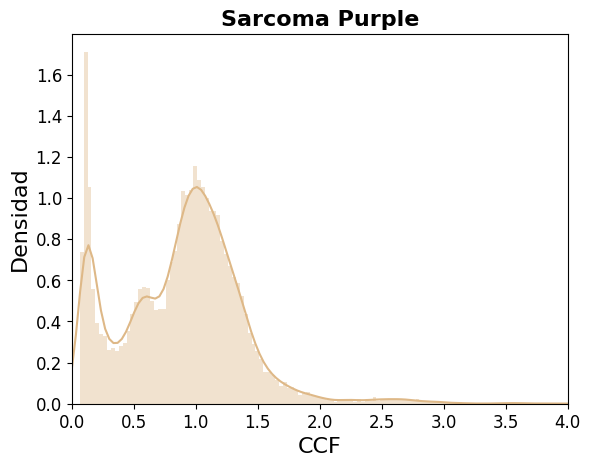

In [25]:
# Represent histogram with density plot to find the minimum 
ax = sns.distplot(ccf, bins=200, color = 'burlywood')
plt.title('Sarcoma Purple', fontsize=16, weight='bold')
plt.xlim([0,4])
plt.xlabel('CCF', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 5/ CCF threshold to obtain clonal mutations

In [26]:
# Extract graph data corresponding to x values and y values
ccf_x, ccf_y = ax.lines[0].get_data()
print(len(ccf_x),len(ccf_y)) #these returns 200, the number of bins used

200 200


In [27]:
# Find the range of x values where we set the threshold to find clonal mutations:
for threshold_x in ccf_x:
    range1 = 0.3 #check these values in x axis in CCF graph
    if  threshold_x > range1:
        print("This is the X threshold of clonal mutations:", threshold_x)
        break

This is the X threshold of clonal mutations: 0.30259548527223074


In [28]:
# Find the bin number where X threshold is set: 
for n in range(len(ccf_x)):
    if ccf_x[n] == threshold_x:
        print('This is the position (bin) where this value comes from:', n)

This is the position (bin) where this value comes from: 13


In [29]:
# Corroborate this position obtained returns the same value:
ccf_x[21]

0.5717771234945193

In [30]:
# Round the X threshold float number
round(threshold_x, 6) # 6 is the number of digits we want to obtain

0.302595

In [31]:
# The histogram of CCF has values sorted. So to find the position (bin) to cut-off clonal mutations values have to be sorted accordingly
ccf_sorted = ccf.sort_values(ascending=True)

In [32]:
# Obtain the CCF values greater than the threshold
ccf_clonal =[]
for i in ccf_sorted:
    if i > threshold_x:
        ccf_clonal.append(i)

In [33]:
# Check the minimum and maxiumum of filtered values
print(min(ccf_clonal))
print(max(ccf_clonal))

0.3028429788484135
6.362378115942029


/tmp/jobs/efiguerola/9577475/ipykernel_3551618/3780717503.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ccf, bins=200, color = 'burlywood')


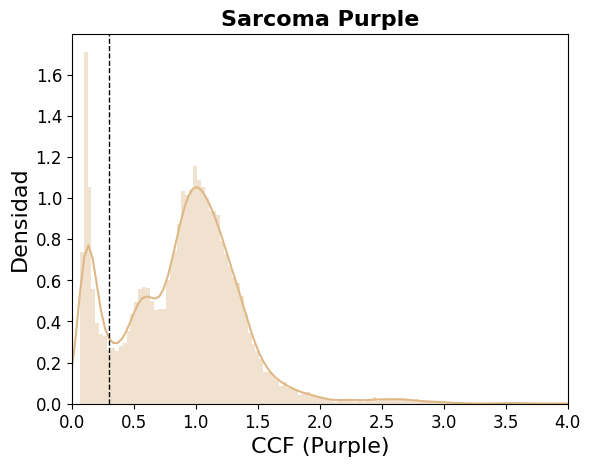

In [34]:
# Represent the previous density plot with the limit set on clonal mutations and export this image
ax = sns.distplot(ccf, bins=200, color = 'burlywood')
plt.title('Sarcoma Purple', fontsize=16, weight='bold')
plt.xlim([0,4])
plt.xlabel('CCF (Purple)', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=threshold_x, color='k', linestyle='dashed', linewidth=1)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_ccf_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show()

In [35]:
# Define a function that adds if the mutation is clonal or subclonal to the mutations_cnv_df
def clonality(row):
    for i in ccf_clonal:
        if i == row['CCF']:
            return 'clonal'

mutations_cnv_df['clonality'] = mutations_cnv_df.progress_apply(clonality, axis=1)

  0%|          | 0/24295 [00:00<?, ?it/s]

In [36]:
mutations_cnv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,1.4411,0.935860,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,1.4411,1.195821,clonal
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,1.4411,0.103220,None
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,1.4411,0.741439,clonal
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,1.4411,1.452197,clonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24290,chrY,26654389,.,A,G,864,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,19,57,0.683000,SNV,Strelka_SAGE,sarcoma,chrY_26654389_A_G,0.5867,1.014426,clonal
24291,chrY,56823266,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=487,411|29,27...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:456,0:2.167e-03:456:195,0:201,0:448,0:238,...",...,442,456,0.112450,SNV,Mutect_Strelka,sarcoma,chrY_56823266_G_A,0.5867,0.167016,None
24292,chrY,56842066,.,CT,AC,1323,PASS,LPS=6133;LPS_RC=42;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,169,290,0.305000,MNV,Mutect_SAGE,sarcoma,chrY_56842066_CT_AC,0.5867,0.453001,clonal
24293,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=241,235|34,34...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,181,295,0.273092,SNV,Mutect_Strelka,sarcoma,chrY_56842087_T_C,0.5867,0.405611,clonal


In [37]:
# Fill "None" values from 'clonality' column with "subclonal"
mutations_cnv_df['clonality'].fillna(value='subclonal', inplace = True)
display(mutations_cnv_df)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,1.4411,0.935860,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,1.4411,1.195821,clonal
2,chr1,1014876,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=162,109|4,2;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:141,0:7.025e-03:141:64,0:69,0:139,0:85,56,0,0",...,130,141,0.044118,SNV,Mutect_Strelka,sarcoma,chr1_1014876_G_T,1.4411,0.103220,subclonal
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,1.4411,0.741439,clonal
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,1.4411,1.452197,clonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24290,chrY,26654389,.,A,G,864,PASS,RC=GGAGAGGAAT;RC_IDX=6;RC_LF=GTAATGGAGT;RC_NM=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:57,0:0:58:2084,0:63,0:0,0,0,0,0,57,58:0:...",...,19,57,0.683000,SNV,Strelka_SAGE,sarcoma,chrY_26654389_A_G,0.5867,1.014426,clonal
24291,chrY,56823266,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=487,411|29,27...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:456,0:2.167e-03:456:195,0:201,0:448,0:238,...",...,442,456,0.112450,SNV,Mutect_Strelka,sarcoma,chrY_56823266_G_A,0.5867,0.167016,subclonal
24292,chrY,56842066,.,CT,AC,1323,PASS,LPS=6133;LPS_RC=42;RC=ACACACAG;RC_IDX=2;RC_LF=...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:290,0:0:290:9437,0:306,0:0,0,0,0,0,290,2...",...,169,290,0.305000,MNV,Mutect_SAGE,sarcoma,chrY_56842066_CT_AC,0.5867,0.453001,clonal
24293,chrY,56842087,.,T,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=241,235|34,34...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:295,0:3.303e-03:295:143,0:125,0:295,0:1|0:...",...,181,295,0.273092,SNV,Mutect_Strelka,sarcoma,chrY_56842087_T_C,0.5867,0.405611,clonal


In [38]:
# PRIOR TO EXPORT TABLE CHECK IF THEY ARE DUPLICATED ROWS!
# Just in case, apply this function to drop duplicated rows according to CHROM, POS, REF, ALT columns
mutations_cnv_df = mutations_cnv_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'])

In [39]:
mutations_cnv_df.shape

(24295, 27)

In [40]:
# Save this table as new table tsv.gz
# mutations_cnv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_CCF_Purple_all_mutations.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [41]:
# Extract the list of clonal mutations in a new table
mutations_clonal_df = mutations_cnv_df[mutations_cnv_df['clonality'] == 'clonal']
mutations_clonal_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_ref_reads,n_ref_reads,VAF,mut_type,Caller_intersec,SAMPLE,mut,CN,CCF,clonality
0,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=36,157|24,22;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.128e-03:124:33,0:29,0:125,0:0|1:10...",...,69,124,0.400000,SNV,Mutect_Strelka,sarcoma,chr1_104188_C_A,1.4411,0.935860,clonal
1,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=105,87|38,31;...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,66,126,0.511111,SNV,Mutect_Strelka,sarcoma,chr1_843320_G_A,1.4411,1.195821,clonal
3,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=120,130|19,26...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,97,153,0.316901,SNV,Mutect_Strelka,sarcoma,chr1_1118520_C_T,1.4411,0.741439,clonal
4,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=86,92|45,45;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,55,123,0.620690,SNV,Mutect_Strelka,sarcoma,chr1_1136548_G_T,1.4411,1.452197,clonal
5,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=136,140|23,19...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,109,167,0.278146,SNV,Mutect_Strelka,sarcoma,chr1_1182738_C_T,1.4411,0.650764,clonal


In [42]:
# PRIOR TO EXPORT TABLE CHECK IF THEY ARE DUPLICATED ROWS!
# Just in case, apply this function to drop duplicated rows according to CHROM, POS, REF, ALT columns
mutations_clonal_df = mutations_clonal_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'])

In [43]:
# See that there were 2 rows duplicated!
mutations_clonal_df.shape 

(20267, 27)

In [44]:
# Save this table as new table tsv.gz
# mutations_clonal_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_CCF_Purple_clonal_mutations.tsv.gz', sep ='\t', index=None, compression = "gzip")